# TensorFlow Hub 模型复用

在软件开发中，我们经常复用开源软件或者库，避免了相同功能的代码重复开发，减少了大量的重复劳动，也有效缩短了软件开发周期。代码复用，对软件产业的蓬勃发展，有着极大的助推作用。

相应的，TF Hub 目的是为了更好的复用已训练好且经过充分验证的模型，可节省海量的训练时间和计算资源。这些预训练好的模型，可以进行直接部署，也可以进行迁移学习（Transfer Learning）。对个人开发者来说，TF Hub 是非常有意义的，他们可以快速复用像谷歌这样的大公司使用海量计算资源训练的模型，而他们个人去获取这些资源是很不现实的。

## TF Hub 网站 
打开主页 `https://tfhub.dev/` ，在左侧有 Text、Image、Video 和 Publishers 等选项，可以选取关注的类别，然后在顶部的搜索框输入关键字可以搜索模型。

以 `stylization` 为例，我们搜索到模型，模型的地址如下：

https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

其中，末尾的 `2` 为该模型的版本号。

提示

1. 注意目前还有很多模型是基于 TF1.0 的，选择的过程中请注意甄别，有些模型会明确写出来是试用哪个版本，或者，检查使用是否是 tfhub 0.5.0 或以上版本的 API `hub.load(url)` ，在之前版本使用的是 `hub.Module(url)` 。
2. 如果不能访问 tfhub.dev，请大家转换域名到国内镜像 `https://hub.tensorflow.google.cn/` ，模型下载地址也需要相应转换。

## TF Hub 安装 

TF Hub 是单独的一个库，需要单独安装，安装命令如下：

```
pip install tensorflow-hub
```

提示

在 TF2.0 上，必须使用 0.5.0 或以上版本，因为接口有变动。

## TF Hub 模型使用样例 

TF Hub 模型的复用非常简单，代码模式如下：

## 模式的使用范例
https://hub.tensorflow.google.cn/google/magenta/arbitrary-image-stylization-v1-256/2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
def crop_center(image):
    """Returns a cropped square image."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
    return image

In [5]:
def load_image_local(image_path, image_size=(512, 512), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
    # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
    img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
    if img.max() > 1.0:
        img = img / 255.
    if len(img.shape) == 3:
        img = tf.stack([img, img, img], axis=-1)
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

In [10]:
def show_image(image, title, save=False):
    plt.imshow(image, aspect='equal')
    plt.axis('off')
    if save:
        plt.savefig(title + '.png', bbox_inches='tight',pad_inches=0.0)
    else:
        plt.show()

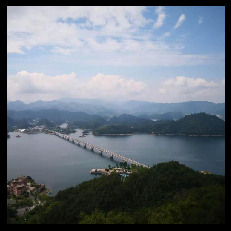

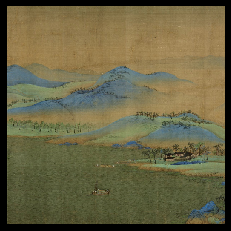

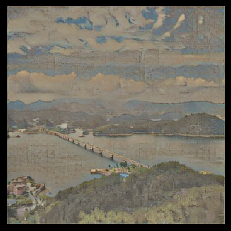

In [11]:
content_image_path = "images/contentimg.jpeg"
style_image_path = "images/styleimg.jpeg"

content_image = load_image_local(content_image_path)
style_image = load_image_local(style_image_path)

show_image(content_image[0], "Content Image")
show_image(style_image[0], "Style Image")

# Load image stylization module.
hub_module = hub.load('https://hub.tensorflow.google.cn/google/magenta/arbitrary-image-stylization-v1-256/2');

# Stylize image.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

show_image(stylized_image[0], "Stylized Image", True)

## TF Hub 模型 retrain 样例 

相信预预训练的模型不一定满足开发者的实际诉求，还需要进行二次训练。针对这种情况，TF Hub 提供了很方便的 Keras 接口 `hub.KerasLayer(url)` ，其可以封装在 Keras 的 `Sequential` 层状结构中，进而可以针对开发者的需求和数据进行再训练。

模型网址
https://hub.tensorflow.google.cn/google/tf2-preview/inception_v3/feature_vector/4

我们以 `inception_v3` 的模型为例，简单介绍 `hub.KerasLayer(url)` 使用的方法：

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

num_classes = 10

# 使用 hub.KerasLayer 组件待训练模型
new_model = tf.keras.Sequential([
    hub.KerasLayer("https://hub.tensorflow.google.cn/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
new_model.build([None, 299, 299, 3])

# 输出模型结构
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
dense (Dense)                multiple                  20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
